##import

### import

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pycaret.regression import *
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import joblib
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pycaret import *
from xgboost import XGBRegressor

### 메소드

In [2]:

# smape 계산 함수
def smape_fnc(true, pred):
  v = 2*abs(pred-true)/(abs(pred)+abs(true))
  output=np.mean(v)*100
  return output

# custom metrics
def custom_metrics(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

### 데이터 불러오기

In [42]:
path_drive = './data/'
path = './'

In [43]:
combined_clust_df = pd.read_csv(path_drive+'combined_clust_df.csv')
test_df = pd.read_csv(path_drive + 'test_df.csv')

## 군집화

### 각 군집별로 모델 생성(et) +모델별 feature 추가

Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']  
Cluster 1: ['백화점및아울렛', '호텔및리조트']  
Cluster 2: ['데이터센터', '아파트']  
Cluster 3: ['공공', '병원', '상용', '지식산업센터']

In [44]:
clust_to_num = {0: [1, 3, 9, 11], 1: [5, 12], 2: [4, 8], 3: [2, 6, 7, 10]}

In [45]:
model_type = 'et'


#### clust0

In [46]:
combined_clust_df['요일_sin'] = -np.sin(2 * np.pi * (combined_clust_df['요일']+1)/7.0)
combined_clust_df['요일_cos'] = -np.cos(2 * np.pi * (combined_clust_df['요일']+1)/7.0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


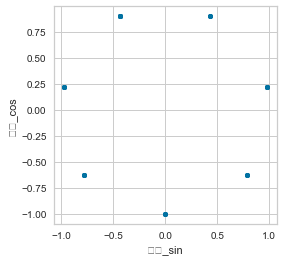

In [47]:
combined_clust_df.sample(50).plot.scatter('요일_sin','요일_cos').set_aspect('equal');

In [54]:
combined_clust_df.columns

Index(['건물번호', '일시', '기온(C)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '불쾌지수',
       '불쾌지수_이동평균3', '불쾌지수_이동평균5', 'holiday', '월', '일', '시간', '시간_sin',
       '시간_cos', '요일', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', '건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용',
       '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트', '건물유형_라벨', '태양광여부',
       'km_cluster', 'datetime', 'work_time', 'low_day', 'particular',
       '요일_sin', '요일_cos'],
      dtype='object')

##### 변수 중요도

In [53]:
X_train

,건물번호,일시,기온(C),풍속(m/s),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,...,호텔및리조트,건물유형_라벨,태양광여부,km_cluster,datetime,work_time,low_day,particular,요일_sin,요일_cos
326,1,2022-06-14 14:00:00,25.9,3.7,48.0,72.72268,73.209220,72.484480,False,6,...,0,1,False,0,2022-06-14,1,0,0,-9.749279e-01,0.222521
7478,4,2022-07-27 14:00:00,32.4,2.3,58.0,82.85408,82.505533,81.650314,False,7,...,0,1,True,0,2022-07-27,1,0,0,-4.338837e-01,0.900969
35395,26,2022-06-30 19:00:00,21.3,1.0,99.0,70.27213,70.451140,70.794002,False,6,...,0,3,True,0,2022-06-30,0,0,0,4.338837e-01,0.900969
17095,9,2022-07-03 07:00:00,26.6,0.3,73.0,76.63082,74.500210,74.340092,True,7,...,0,1,False,0,2022-07-03,1,0,0,2.449294e-16,-1.000000
55876,73,2022-07-04 04:00:00,25.8,0.4,64.0,74.39288,74.479387,74.715032,False,7,...,0,9,True,0,2022-07-04,0,0,0,-7.818315e-01,-0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,4,2022-06-07 01:00:00,16.6,5.2,62.0,61.06908,61.258920,61.922290,False,6,...,0,1,True,0,2022-06-07,0,0,0,-9.749279e-01,0.222521
54886,72,2022-08-16 22:00:00,25.6,1.0,99.0,77.96956,78.148570,78.649798,False,8,...,0,9,True,0,2022-08-16,0,0,0,-9.749279e-01,0.222521
76820,91,2022-07-26 20:00:00,28.1,1.8,79.0,79.74101,80.480817,81.492462,False,7,...,0,11,False,0,2022-07-26,1,0,0,-9.749279e-01,0.222521
860,1,2022-07-06 20:00:00,31.8,2.6,67.0,83.56994,83.983437,84.194166,False,7,...,0,1,False,0,2022-07-06,1,0,0,-4.338837e-01,0.900969


In [104]:
col = ['건물번호', '기온(C)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '불쾌지수',
       '불쾌지수_이동평균3', 'holiday', '월', '일', '시간', '시간_sin',
       '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', '건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용',
       '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트', '건물유형_라벨', '태양광여부',
       'km_cluster', 'work_time', 'low_day', 'particular',
       '요일_sin', '요일_cos']
combined_clust_train_df = combined_clust_df[col]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)

# Feature와 Target을 분리합니다.
X = clust0_train_df.drop(columns=['전력소비량(kWh)'])
y = clust0_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df


,Feature,Importance
13,연면적(m2),0.621768
25,연구소,0.089153
32,work_time,0.057310
0,건물번호,0.053743
6,holiday,0.034616
34,particular,0.025677
14,냉방면적(m2),0.024330
11,시간_cos,0.023959
19,대학교,0.023825
4,불쾌지수,0.010269


In [105]:
non_zero_importance_columns_0 = importance_df[importance_df['Importance'] != 0]['Feature'].tolist()
non_zero_importance_columns_0

['연면적(m2)',
 '연구소',
 'work_time',
 '건물번호',
 'holiday',
 'particular',
 '냉방면적(m2)',
 '시간_cos',
 '대학교',
 '불쾌지수',
 'low_day',
 '시간',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '월',
 '시간_sin',
 '기온(C)',
 '요일_sin',
 '요일',
 '일',
 '요일_cos',
 '습도(%)',
 '풍속(m/s)']

In [113]:
# selected_columns0 = ['전력소비량(kWh)',
#  '연면적(m2)',
#  '건물번호',
#  '시간_cos',
#  '연구소',
#  'holiday',
#  '냉방면적(m2)',
#  'ESS저장용량(kWh)',
#  '불쾌지수',
#  '대학교',
#  '시간',
#  '시간_sin',
#  '불쾌지수_이동평균3',
#  '태양광용량(kW)',
#  '월',
#  '불쾌지수_이동평균5',
#  '기온(C)',
#  '요일',
#  '일',
#  '습도(%)',
#  '풍속(m/s)',
#  'km_cluster']
selected_columns0 = ['연면적(m2)',
 '연구소',
 'work_time',
 '건물번호',
 'holiday',
 'particular',
 '냉방면적(m2)',
 '시간_cos',
 '대학교',
 '불쾌지수',
 'low_day',
 '시간',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '월',
 '시간_sin',
 '기온(C)',
 '요일_sin',
 '요일',
 '일',
 'km_cluster', '전력소비량(kWh)']

combined_clust_train_df = combined_clust_df[selected_columns0]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [114]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust0_train_df, clust0_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

,Description,Value
0,Session id,3605
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(63648, 22)"
4,Transformed data shape,"(63648, 22)"
5,Transformed train set shape,"(44553, 22)"
6,Transformed test set shape,"(19095, 22)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,87.2385,23408.3311,152.9978,0.9978,0.0810,0.0444
1,87.2990,23364.4791,152.8544,0.9978,0.0738,0.0428
2,87.2398,23488.2115,153.2586,0.9977,0.0831,0.0449
3,87.2170,25667.2519,160.2100,0.9971,0.0837,0.0457
4,90.3986,25332.3011,159.1612,0.9974,0.0796,0.0455
5,88.5279,23929.8187,154.6927,0.9977,0.0849,0.0465
6,90.2204,25853.8771,160.7914,0.9975,0.0845,0.0458
7,87.5265,26333.1825,162.2750,0.9971,0.0858,0.0462
8,90.3507,25171.0855,158.6540,0.9972,0.0816,0.0456


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,77.2815,19083.8818,138.1444,0.9981,0.0721,0.0391


SMAPE: 3.80118


변수 3개 추가 / 제출용

In [9]:
selected_columns0 = ['전력소비량(kWh)',
 '연면적(m2)',
  '연구소',
  'work_time',
  '건물번호',
  'holiday',
  'particular',
  '냉방면적(m2)',
  '시간_cos',
  '대학교',
  '불쾌지수',
  'low_day',
  '불쾌지수_이동평균3',
  '시간',
  '태양광용량(kW)',
  'ESS저장용량(kWh)',
  '월',
  '불쾌지수_이동평균5',
  '시간_sin',
  '기온(C)',
  '요일',
  '일',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns0]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [10]:

# pycaret 설정
exp0 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'0')




,Description,Value
0,Session id,6796
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 22)"
4,Transformed data shape,"(79560, 22)"
5,Transformed train set shape,"(55692, 22)"
6,Transformed test set shape,"(23868, 22)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,85.5369,22836.7103,151.1182,0.9977,0.0777,0.0429
1,84.9268,21647.2378,147.1300,0.9978,0.0814,0.0441
2,86.5083,23229.5114,152.4123,0.9977,0.0819,0.0446
3,89.3934,24769.8236,157.3843,0.9977,0.0874,0.0463
4,84.3798,22096.0390,148.6474,0.9977,0.0847,0.0447
5,86.0122,25051.9604,158.2781,0.9973,0.0842,0.0448
6,88.0072,28875.5904,169.9282,0.9972,0.0799,0.0438
7,88.1737,25700.7631,160.3146,0.9976,0.0830,0.0450
8,83.6390,20956.8908,144.7650,0.9980,0.0745,0.0421


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\yeji4\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['연면적(m2)', '연구소', 'work_time',
                                              '건물번호', 'particular', '냉방면적(m2)',
                                              '시간_cos', '대학교', '불쾌지수', 'low_day',
                                              '불쾌지수_이동평균3', '시간', '태양광용량(kW)',
                                              'ESS저장용량(kWh)', '월', '불쾌지수_이동평균5',
                                              '시간_sin', '기온(C)', '요일', '일'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
      

#### clust1

##### 변수 중요도

In [115]:
col = ['건물번호', '기온(C)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '불쾌지수',
       '불쾌지수_이동평균3', 'holiday', '월', '일', '시간', '시간_sin',
       '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', '건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용',
       '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트', '건물유형_라벨', '태양광여부',
       'km_cluster', 'work_time', 'low_day', 'particular',
       '요일_sin', '요일_cos']

combined_clust_train_df = combined_clust_df[col]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)

# Feature와 Target을 분리합니다.
X = clust1_train_df.drop(columns=['전력소비량(kWh)'])
y = clust1_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

non_zero_importance_columns_1 = importance_df[importance_df['Importance'] != 0]['Feature'].tolist()
non_zero_importance_columns_1

['work_time',
 '연면적(m2)',
 '냉방면적(m2)',
 '시간',
 '시간_cos',
 '건물번호',
 '불쾌지수',
 '월',
 '기온(C)',
 '요일',
 '시간_sin',
 'holiday',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 '일',
 '습도(%)',
 '요일_cos',
 '풍속(m/s)',
 '요일_sin']

In [122]:
# selected_columns1 = ['전력소비량(kWh)',
#  '시간_cos',
#  '냉방면적(m2)',
#  '시간',
#  '연면적(m2)',
#  '시간_sin',
#  '건물번호',
#  '불쾌지수_이동평균3',
#  '월',
#  '불쾌지수',
#  'holiday',
#  '요일',
#  '태양광용량(kW)',
#  '일',
#  'km_cluster']
selected_columns1 = ['work_time',
 '연면적(m2)',
 '냉방면적(m2)',
 '시간',
 '시간_cos',
 '건물번호',
 '불쾌지수',
 '월',
 '기온(C)',
 '요일',
 '시간_sin',
 'holiday',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 '일',
 '습도(%)',
 'km_cluster', '전력소비량(kWh)']

combined_clust_train_df = combined_clust_df[selected_columns1]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [123]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust1_train_df, clust1_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

,Description,Value
0,Session id,2724
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(26112, 17)"
4,Transformed data shape,"(26112, 17)"
5,Transformed train set shape,"(18278, 17)"
6,Transformed test set shape,"(7834, 17)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,76.8626,25928.4078,161.0230,0.9865,0.1048,0.0578
1,79.8199,26010.7142,161.2784,0.9866,0.0949,0.0544
2,82.3212,28260.8100,168.1095,0.9850,0.1038,0.0586
3,71.8134,21177.2501,145.5241,0.9890,0.0939,0.0529
4,81.2835,23936.5732,154.7145,0.9870,0.0971,0.0569
5,76.6504,25019.7281,158.1763,0.9856,0.0939,0.0547
6,85.0134,37573.4466,193.8387,0.9796,0.1852,0.0590
7,79.5186,24138.8853,155.3669,0.9873,0.0905,0.0540
8,76.9721,20409.4556,142.8617,0.9892,0.0949,0.0544


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,72.3342,22510.6877,150.0356,0.9877,0.0986,0.0539


SMAPE: 5.07264


변수 3개 추가 / 제출용

In [ ]:
selected_columns1 = ['전력소비량(kWh)',
'work_time', '연면적(m2)', '냉방면적(m2)', '시간', '건물번호', '시간_cos', '불쾌지수', '월', '기온(C)', 'holiday', '시간_sin', '불쾌지수_이동평균3', '요일', '불쾌지수_이동평균5', '일', '습도(%)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns1]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [ ]:
# pycaret 설정
exp0 = setup(data=clust1_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'1')

#### clust2

##### 변수 중요도

In [124]:
col = ['건물번호', '기온(C)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '불쾌지수',
       '불쾌지수_이동평균3', 'holiday', '월', '일', '시간', '시간_sin',
       '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', '건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용',
       '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트', '건물유형_라벨', '태양광여부',
       'km_cluster', 'work_time', 'low_day', 'particular',
       '요일_sin', '요일_cos']

combined_clust_train_df = combined_clust_df[col]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)

# Feature와 Target을 분리합니다.
X = clust2_train_df.drop(columns=['전력소비량(kWh)'])
y = clust2_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

non_zero_importance_columns_2 = importance_df[importance_df['Importance'] != 0]['Feature'].tolist()
non_zero_importance_columns_2

['건물번호',
 '냉방면적(m2)',
 'work_time',
 '불쾌지수_이동평균3',
 '시간',
 '연면적(m2)',
 '월',
 '불쾌지수',
 '시간_sin',
 'holiday',
 '시간_cos',
 '요일',
 '일',
 '습도(%)',
 '요일_sin',
 '요일_cos',
 '기온(C)',
 '풍속(m/s)']

In [131]:
# selected_columns2 = ['전력소비량(kWh)',
#  '건물번호',
#  '냉방면적(m2)',
#  '연면적(m2)',
#  '시간',
#  '불쾌지수',
#  '월',
#  '시간_sin',
#  '불쾌지수_이동평균3',
#  'holiday',
#  '시간_cos',
#  '일',
#  '습도(%)',
#  '요일',
#  '기온(C)',
#  '풍속(m/s)',
#  'km_cluster']
selected_columns2 = ['건물번호',
 '냉방면적(m2)',
 'work_time',
 '불쾌지수_이동평균3',
 '시간',
 '연면적(m2)',
 '월',
 '불쾌지수',
 '시간_sin',
 'holiday',
 '시간_cos',
 '요일',
 '일',
 '습도(%)',
 '요일_sin',
 'km_cluster', '전력소비량(kWh)']

combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [132]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust2_train_df, clust2_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

,Description,Value
0,Session id,8139
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(19488, 16)"
4,Transformed data shape,"(19488, 16)"
5,Transformed train set shape,"(13641, 16)"
6,Transformed test set shape,"(5847, 16)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,36.2884,3935.7271,62.7354,0.9995,0.0446,0.0259
1,34.1687,3452.4004,58.7571,0.9995,0.0422,0.0245
2,37.7574,5221.5357,72.2602,0.9992,0.0397,0.0246
3,38.5847,5347.3934,73.1259,0.9991,0.0470,0.0269
4,39.5006,5751.8058,75.8407,0.9991,0.0415,0.0253
5,38.4012,8564.9480,92.5470,0.9987,0.0561,0.0276
6,36.3350,3788.2060,61.5484,0.9995,0.0428,0.0262
7,36.2504,4705.5185,68.5968,0.9994,0.0450,0.0251
8,36.2466,4174.8019,64.6127,0.9994,0.0396,0.0242


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,30.8698,3160.7051,56.2201,0.9995,0.0374,0.0219


SMAPE: 2.18683


변수 3개 추가 / 제출용

In [ ]:
selected_columns2 = ['전력소비량(kWh)',
 '건물번호',
 '냉방면적(m2)',
 '불쾌지수_이동평균5',
 '연면적(m2)',
 '시간',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 'holiday',
 '시간_cos',
 '일',
 '습도(%)',
 '요일',
 '기온(C)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:
# pycaret 설정
exp0 = setup(data=clust2_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'2')

#### clust3

##### 변수 중요도 

In [133]:
col = ['건물번호', '기온(C)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '불쾌지수',
       '불쾌지수_이동평균3', 'holiday', '월', '일', '시간', '시간_sin',
       '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', '건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용',
       '아파트', '연구소', '지식산업센터', '할인마트', '호텔및리조트', '건물유형_라벨', '태양광여부',
       'km_cluster', 'work_time', 'low_day', 'particular',
       '요일_sin', '요일_cos']

combined_clust_train_df = combined_clust_df[col]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)

# Feature와 Target을 분리합니다.
X = clust3_train_df.drop(columns=['전력소비량(kWh)'])
y = clust3_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

non_zero_importance_columns_3 = importance_df[importance_df['Importance'] != 0]['Feature'].tolist()
non_zero_importance_columns_3

['병원',
 'work_time',
 'low_day',
 '연면적(m2)',
 '냉방면적(m2)',
 'holiday',
 '시간_cos',
 'ESS저장용량(kWh)',
 '건물번호',
 '태양광용량(kW)',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 '상용',
 '시간',
 '기온(C)',
 '일',
 '요일',
 '요일_sin',
 '습도(%)',
 'particular',
 '풍속(m/s)',
 '요일_cos']

In [142]:
# selected_columns3 = ['전력소비량(kWh)',
#  '병원',
#  '시간_cos',
#  '연면적(m2)',
#  'holiday',
#  '냉방면적(m2)',
#  '건물번호',
#  '태양광용량(kW)',
#  'ESS저장용량(kWh)',
#  '불쾌지수',
#  '시간_sin',
#  '상용',
#  '월',
#  '불쾌지수_이동평균3',
#  '시간',
#  '요일',
#  '기온(C)',
#  '일',
#  '습도(%)',
#  'km_cluster']
selected_columns3 = ['병원',
 'work_time',
 'low_day',
 '연면적(m2)',
 '냉방면적(m2)',
 'holiday',
 '시간_cos',
 'ESS저장용량(kWh)',
 '건물번호',
 '태양광용량(kW)',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 '상용',
 '시간',
 '기온(C)',
 '일',
 '요일',
 '요일_sin',
 '습도(%)',
 'km_cluster', '전력소비량(kWh)']

combined_clust_train_df = combined_clust_df[selected_columns3]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



In [144]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust3_train_df, clust3_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

,Description,Value
0,Session id,7799
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(52224, 22)"
4,Transformed data shape,"(52224, 22)"
5,Transformed train set shape,"(36556, 22)"
6,Transformed test set shape,"(15668, 22)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,64.4518,11368.8491,106.6248,0.9928,0.0563,0.0334
1,64.2721,12431.9624,111.4987,0.9923,0.0594,0.0334
2,63.8777,12201.7639,110.4616,0.9919,0.0592,0.0334
3,63.9531,11302.2528,106.3121,0.9930,0.0581,0.0337
4,60.3112,10745.3590,103.6598,0.9933,0.0543,0.0314
5,63.2530,12849.5682,113.3559,0.9920,0.0632,0.0341
6,61.2900,11014.8220,104.9515,0.9928,0.0530,0.0318
7,63.5208,11792.2810,108.5923,0.9923,0.0597,0.0334
8,62.3097,11534.9295,107.4008,0.9925,0.0556,0.0324


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,55.1101,8804.3844,93.8317,0.9944,0.0505,0.0285


SMAPE: 2.81708


변수 3개 추가 / 제출용

In [ ]:
selected_columns3 = ['전력소비량(kWh)',
'work_time',
 '연면적(m2)',
 '냉방면적(m2)',
 '시간',
 '건물번호',
 '시간_cos',
 '불쾌지수',
 '월',
 '기온(C)',
 'holiday',
 '시간_sin',
 '불쾌지수_이동평균3',
 '요일',
 '불쾌지수_이동평균5',
 '일',
 '습도(%)',
 '풍속(m/s)',
 '태양광용량(kW)',
'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns3]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



In [ ]:
# pycaret 설정
exp0 = setup(data=clust3_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'3')

### 예측

In [ ]:
selected_columns0.append('건물유형_라벨')
selected_columns1.append('건물유형_라벨')
selected_columns2.append('건물유형_라벨')
selected_columns3.append('건물유형_라벨')

rm_list = ['전력소비량(kWh)', 'km_cluster']
for value in rm_list:
    selected_columns0.remove(value)
    selected_columns1.remove(value)
    selected_columns2.remove(value)
    selected_columns3.remove(value)


test_df_list = [test_df[selected_columns0],test_df[selected_columns1],test_df[selected_columns2],test_df[selected_columns3]]

In [ ]:

# 예측값을 저장할 컬럼
test_df['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():
    # 해당 클러스터의 모델 불러오기
    cluster_model = load_model( path+model_type++ str(cluster))

    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_list[cluster][test_df_list[cluster]['건물유형_라벨'].isin(building_labels)]
    cluster_test_data = cluster_test_data.drop(columns=['건물유형_라벨'])
    index_list = cluster_test_data.index.tolist()

    # 불러온 모델로 예측 수행
    predictions = predict_model(cluster_model, cluster_test_data)

    # index_list와 predictions를 이용하여 데이터프레임 생성
    answer_df = pd.DataFrame({'answer': predictions['prediction_label']}, index=index_list)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df.loc[answer_df.index, 'answer'] = answer_df['answer']


test_df

예측 데이터 저장

In [ ]:
sum(test_df['answer'].isna())

In [ ]:
# 데이터 불러오기
df = pd.read_csv(path_drive+'sample_submission.csv')

df['answer'] = test_df['answer']
df.to_csv(path+'submit.csv', index=False)

In [ ]:
len(df[df['answer']<0])